In [1]:
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
cwd = os.getcwd()

%matplotlib inline

import io
import base64
from IPython.display import HTML

#set image color space
colorspace = cv2.COLOR_BGR2RGB

import pickle
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import StandardScaler

from sklearn.svm import LinearSVC, SVC
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.cross_validation import train_test_split
import time
from scipy.ndimage.measurements import label

from moviepy.editor import VideoFileClip
from IPython.display import HTML

import glob

from skimage import data, color, exposure
from skimage.feature import hog

## Step 0: Load The Training Data

Number of training images of cars:  8792
Number of training images of not-cars:  8968


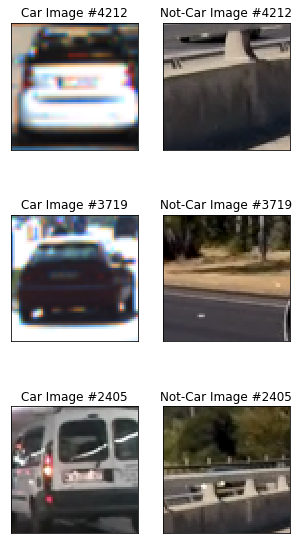

In [2]:
vehicles_dir = ['/Users/chansek/Documents/GitHub/Self-Driving-Car/data/Dashcam/vehicles/GTI_Far',
                '/Users/chansek/Documents/GitHub/Self-Driving-Car/data/Dashcam/vehicles/GTI_Left',
                '/Users/chansek/Documents/GitHub/Self-Driving-Car/data/Dashcam/vehicles/GTI_Right',
                '/Users/chansek/Documents/GitHub/Self-Driving-Car/data/Dashcam/vehicles/GTI_MiddleClose',
                '/Users/chansek/Documents/GitHub/Self-Driving-Car/data/Dashcam/vehicles/KITTI_extracted']

non_vehicles_dir = ['/Users/chansek/Documents/GitHub/Self-Driving-Car/data/Dashcam/non-vehicles/Extras',
                    '/Users/chansek/Documents/GitHub/Self-Driving-Car/data/Dashcam/non-vehicles/GTI']
                
cars = []
notcars = []

for dir_name in vehicles_dir:
    items = os.listdir(dir_name)
    for names in items:
        if names.endswith(".png") or names.endswith(".jpg"):
            img = mpimg.imread(os.path.join(dir_name,names))
            cars.append(img)

for dir_name in non_vehicles_dir:
    items = os.listdir(dir_name)
    for names in items:
        if names.endswith(".png") or names.endswith(".jpg"):
            img = mpimg.imread(os.path.join(dir_name,names))
            notcars.append(img)

print("Number of training images of cars: ", len(cars))
print("Number of training images of not-cars: ", len(notcars))

nSamples = 3
f, axarr = plt.subplots(nSamples,2,figsize=(5, 10))

samples = []
car_imgs = []
notcar_imgs = []

for i in range(nSamples):
    samples.append(random.randint(0, len(cars)))
    car_imgs.append(cars[samples[i]]) 
    notcar_imgs.append(notcars[samples[i]])
    
for i in range(nSamples):
    rand_index = samples[i]
    axarr[i,0].imshow(cars[rand_index])
    axarr[i,1].imshow(notcars[rand_index])
    axarr[i,0].set_xticks([])
    axarr[i,0].set_yticks([])
    axarr[i,0].set_title("Car Image #" + str(rand_index))
    
    axarr[i,1].set_xticks([])
    axarr[i,1].set_yticks([])
    axarr[i,1].set_title("Not-Car Image #" + str(rand_index))    

## Step-0a: Data Description

In [3]:
print(len(cars), len(car_imgs), cars[0].shape)
print(len(notcars), len(notcar_imgs), notcars[0].shape)
print(np.min(cars[0][:,:,0]),np.min(cars[0][:,:,1]),np.min(cars[0][:,:,2]))
print(np.max(cars[0][:,:,0]),np.max(cars[0][:,:,1]),np.max(cars[0][:,:,2]))

8792 3 (64, 64, 3)
8968 3 (64, 64, 3)
0.129412 0.14902 0.133333
0.745098 0.752941 0.690196


## Step 1a: Color Space Transformation
Both HSV & YCrCb were tried. HSV transformation presented issues in detecting white cars on white roads.
YCrCb seemed to be a better choice.

In [4]:
cspace = 'YCrCb'#'HSV'#

def change_cspace(image,color_space):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)
    return feature_image

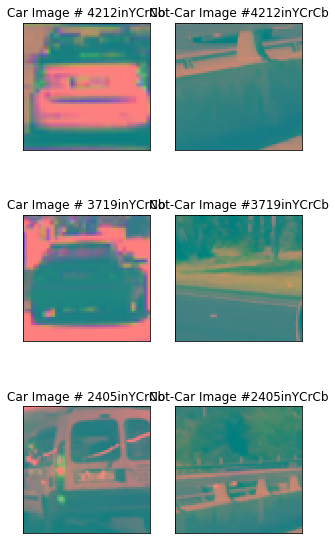

In [5]:
cars_cspace = []
notcars_cspace = []
f, axarr = plt.subplots(nSamples,2,figsize=(5, 10))
for i in range(nSamples):
    if cspace == 'YCrCb':
        cars_cspace.append(change_cspace(car_imgs[i], cspace))
        notcars_cspace.append(change_cspace(notcar_imgs[i], cspace))        
    else:
        cars_cspace.append(change_cspace(car_imgs[i]*255.0, cspace))
        notcars_cspace.append(change_cspace(notcar_imgs[i]*255.0, cspace))
#     print(np.min(cars_cspace[i]),np.max(cars_cspace[i]))
#     print(np.min(notcars_cspace[i]),np.max(notcars_cspace[i]))    
#     print()
    axarr[i,0].imshow(cars_cspace[i])#/255.0)
    axarr[i,1].imshow(notcars_cspace[i])#/255.0)
    axarr[i,0].set_xticks([])
    axarr[i,0].set_yticks([])
    axarr[i,0].set_title("Car Image # " + str(samples[i]) + "in" +  cspace)
    
    axarr[i,1].set_xticks([])
    axarr[i,1].set_yticks([])
    axarr[i,1].set_title("Not-Car Image #" + str(samples[i]) + "in" +  cspace)

## Step 1b: Spatial bins
The pixed values of the raw image transformed into the YCrCb colorspace in Step 1a are then concatenated into a single vector feature for spatial analysis.

In [6]:
spatial_size = (32,32)
def bin_spatial(image, size=(32, 32)):
    features = cv2.resize(image, size).ravel()
    return features

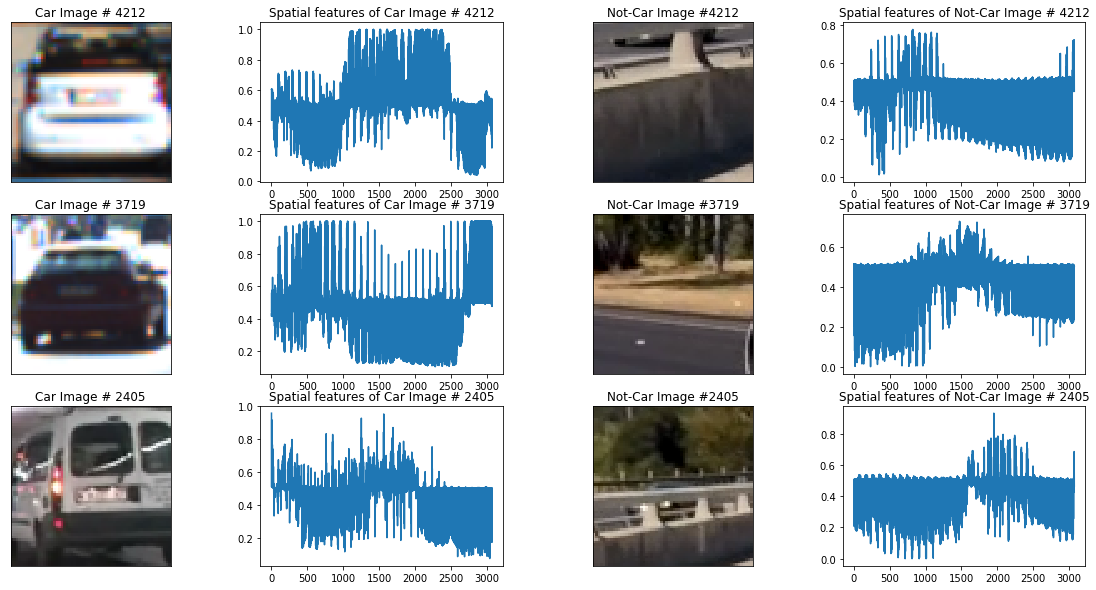

In [7]:
cars_spatialHist = []
notcars_spatialHist = []
f, axarr = plt.subplots(nSamples,4,figsize=(20, 10))
for i in range(nSamples):
    cars_spatialHist.append(bin_spatial(cars_cspace[i]))
    notcars_spatialHist.append(bin_spatial(notcars_cspace[i]))
#     print(np.min(cars_cspace[i]),np.max(cars_cspace[i]),np.min(notcars_cspace[i]),np.max(notcars_cspace[i]))
    axarr[i,0].imshow(cars[samples[i]])
    axarr[i,2].imshow(notcars[samples[i]])
    axarr[i,0].set_xticks([])
    axarr[i,0].set_yticks([])
    axarr[i,0].set_title("Car Image # " + str(samples[i]))
    axarr[i,2].set_xticks([])
    axarr[i,2].set_yticks([])
    axarr[i,2].set_title("Not-Car Image #" + str(samples[i]))
    
    axarr[i,1].plot(range(len(cars_spatialHist[i])),cars_spatialHist[i])
    axarr[i,3].plot(range(len(notcars_spatialHist[i])),notcars_spatialHist[i])
    axarr[i,1].set_title("Spatial features of Car Image # " + str(samples[i]))
    axarr[i,3].set_title("Spatial features of Not-Car Image # " + str(samples[i]))    

## Step-1c: Histogram of color features
The histogram of the raw image is then computed and compared between the sample ar & non-car images.

In [8]:
nbins = 32
def color_hist(image, nbins=32):
    if len(image.shape) > 1:
        features = []
        for i in range(image.shape[2]):
            # Compute the histogram of the color channels separately
            hist,edges = np.histogram(image[:, :, i], bins=nbins)#, range = (0,256))
            features.append(hist)
        hist_features = np.concatenate(features)
    else:
        hist_features, edges = np.histogram(image, bins=nbins)#, range = (0,256))

    return hist_features

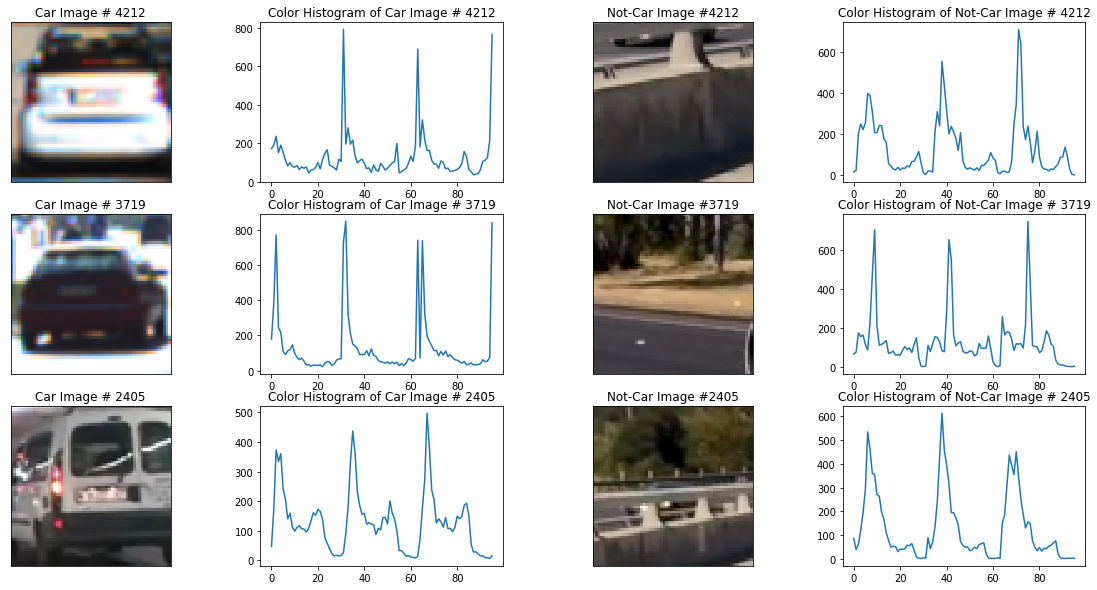

In [9]:
cars_colorHist = []
notcars_colorHist = []
f, axarr = plt.subplots(nSamples,4,figsize=(20, 10))
for i in range(nSamples):
    cars_colorHist.append(color_hist(car_imgs[i]))#cars_cspace[i]))#
    notcars_colorHist.append(color_hist(notcar_imgs[i]))#notcars_cspace[i]))#
    axarr[i,0].imshow(cars[samples[i]])
    axarr[i,2].imshow(notcars[samples[i]])
    axarr[i,0].set_xticks([])
    axarr[i,0].set_yticks([])
    axarr[i,0].set_title("Car Image # " + str(samples[i]))
    axarr[i,2].set_xticks([])
    axarr[i,2].set_yticks([])
    axarr[i,2].set_title("Not-Car Image #" + str(samples[i]))
    
    axarr[i,1].plot(range(len(cars_colorHist[i])),cars_colorHist[i])
    axarr[i,3].plot(range(len(notcars_colorHist[i])),notcars_colorHist[i])
    axarr[i,1].set_title("Color Histogram of Car Image # " + str(samples[i]))
    axarr[i,3].set_title("Color Histogram of Not-Car Image # " + str(samples[i]))  

## Step 1d: HOG feature exploration
For analysis of the directional information in each of the images, the histogram of oriented gradients (hog) is then taken and plotted. While taking the HOG, it is desirable to concatenate the hog information from all channels of the transformed image into a single vector. This will eliminate any biases towards cars of a given color that may arise by just looking at hog from any individual channel

In [10]:
def get_hog_features(image, hog_channel = "ALL", orient = 9, pix_per_cell = 8, cell_per_block = 2,
                     vis=False, feature_vec=True):
    if len(image.shape) > 1 and hog_channel == "ALL":
        features = []
        vis_image = []
        for i in range(image.shape[2]):
            # Compute the histogram of the color channels separately
            hog_vals, hog_image = hog(image[:,:,i], orientations=orient,
                                      pixels_per_cell=(pix_per_cell, pix_per_cell),
                                      cells_per_block=(cell_per_block, cell_per_block),
                                      transform_sqrt=True,
                                      visualise=True, feature_vector=feature_vec)
            if vis_image == []:
                vis_image = hog_image
            else:
                vis_image = np.dstack((vis_image,hog_image))               
            features.append(hog_vals)
        hog_features = np.concatenate(features)
    elif len(image.shape) > 1 and hog_channel != "ALL":
        hog_vals, hog_image = hog(image[:,:,hog_channel], orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
#                                   transform_sqrt=True,
                                  visualise=True, feature_vector=feature_vec)
        hog_features = hog_vals
        vis_image = hog_image
    else:
        hog_vals, hog_image = hog(image, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
#                                   transform_sqrt=True,
                                  visualise=True, feature_vector=feature_vec)
        hog_features = hog_vals
        vis_image = hog_image
        
    if vis == True:
        return hog_features, hog_image
    else:
        return hog_features

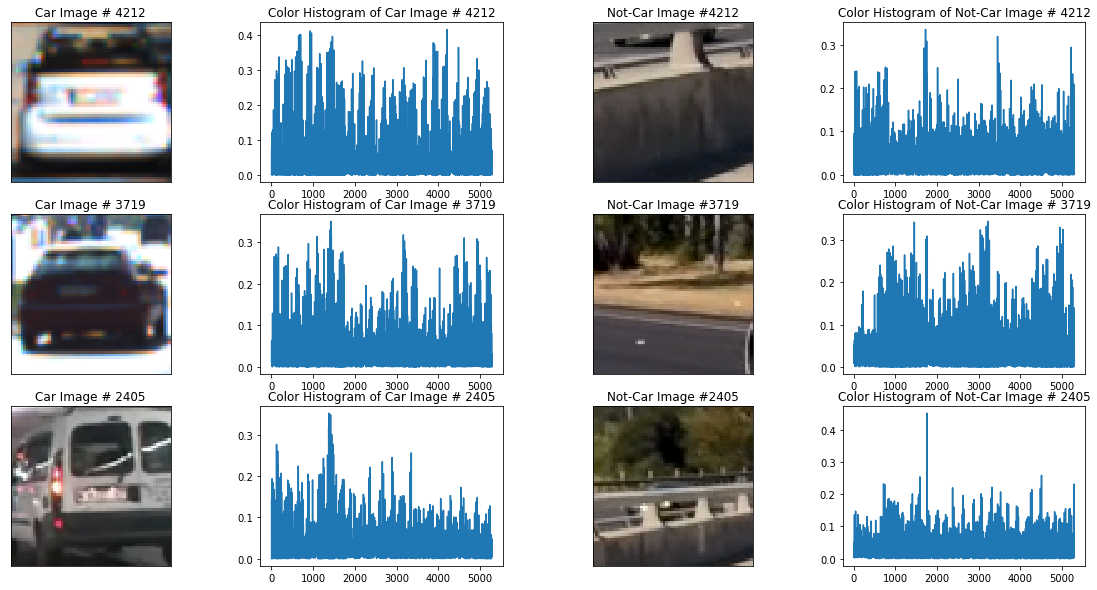

In [11]:
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
vis = True
feature_vec = True

cars_hog = []
notcars_hog = []
f, axarr = plt.subplots(nSamples,4,figsize=(20, 10))
for i in range(nSamples):
    cars_hog.append(get_hog_features(cars_cspace[i]))#,hog_channel = 0))
    notcars_hog.append(get_hog_features(notcars_cspace[i]))#,hog_channel = 0))
    axarr[i,0].imshow(cars[samples[i]])
    axarr[i,2].imshow(notcars[samples[i]])
    axarr[i,0].set_xticks([])
    axarr[i,0].set_yticks([])
    axarr[i,0].set_title("Car Image # " + str(samples[i]))
    axarr[i,2].set_xticks([])
    axarr[i,2].set_yticks([])
    axarr[i,2].set_title("Not-Car Image #" + str(samples[i]))
    
    axarr[i,1].plot(range(len(cars_hog[i])),cars_hog[i])
    axarr[i,3].plot(range(len(notcars_hog[i])),notcars_hog[i])
    axarr[i,1].set_title("Color Histogram of Car Image # " + str(samples[i]))
    axarr[i,3].set_title("Color Histogram of Not-Car Image # " + str(samples[i]))         

## Step 2: Combined Feature Vector
A combined feature vector from the spatial data, color histogram and hog information is then concatenated into a single feature vector for supervised learning.

In [12]:
def single_img_features(image, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # 1) Define an empty list to receive features
    img_features = []
    # 2) Apply color conversion if other than 'RGB'
    feature_image = change_cspace(image,color_space)
    # 3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # 4) Append features to list
        img_features.append(spatial_features)
    # 5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(image, nbins=hist_bins)
        # 6) Append features to list
        img_features.append(hist_features)
    # 7) Compute HOG features if flag is set
    if hog_feat == True:
        hog_features = get_hog_features(feature_image, hog_channel = hog_channel, orient = orient,
                                        pix_per_cell = pix_per_cell, cell_per_block = cell_per_block,
                                        vis=False, feature_vec=True)
        # 8) Append features to list
        img_features.append(hog_features)

    # 9) Return concatenated array of features
    return np.concatenate(img_features)

8460 8460


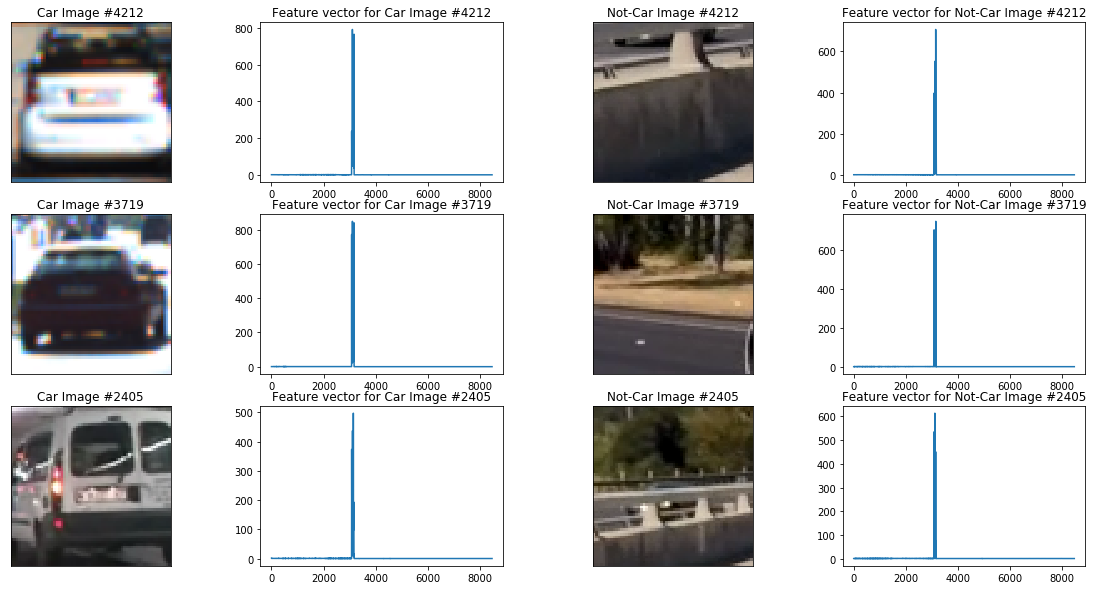

In [13]:
f, axarr5 = plt.subplots(nSamples,4,figsize=(20, 10))
cars_feature_vector_list = []
notcars_feature_vector_list = []
for i in range(nSamples):
    features1 = single_img_features(car_imgs[i], color_space=cspace, spatial_size=spatial_size,
                             hist_bins=nbins, orient=orient, 
                             pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                             spatial_feat=True, hist_feat=True, hog_feat=True)

    features2 = single_img_features(notcar_imgs[i], color_space=cspace, spatial_size=spatial_size,
                             hist_bins=nbins, orient=orient, 
                             pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                             spatial_feat=True, hist_feat=True, hog_feat=True)
    
    cars_feature_vector_list.append(features1)
    notcars_feature_vector_list.append(features2)

print(len(features1), len(features2))
# bin_centers = np.array(range(len(features1[0]))).astype(float)+0.5
for i in range(nSamples):
    axarr5[i,0].imshow(cars[samples[i]])
    axarr5[i,1].plot(range(len(cars_feature_vector_list[i])),cars_feature_vector_list[i])
    axarr5[i,2].imshow(notcars[samples[i]])
    axarr5[i,3].plot(range(len(notcars_feature_vector_list[i])),notcars_feature_vector_list[i])

    axarr5[i,0].set_xticks([])
    axarr5[i,0].set_yticks([])        
    axarr5[i,0].set_title("Car Image #" + str(samples[i]))
    axarr5[i,1].set_title("Feature vector for Car Image #" + str(samples[i]))    
    axarr5[i,2].set_xticks([])
    axarr5[i,2].set_yticks([])        
    axarr5[i,2].set_title("Not-Car Image #" + str(samples[i]))
    axarr5[i,3].set_title("Feature vector for Not-Car Image #" + str(samples[i]))    

## Step 3: Scaling the feature vector
Note that the three features looked at have different scales. The color histogram seems to dominate the overall feature vector. Before supervised learning is started, the feature vector is scaled to overcome any issues with biases that may arise due to the different orders of magnitudes present in the feature vector.

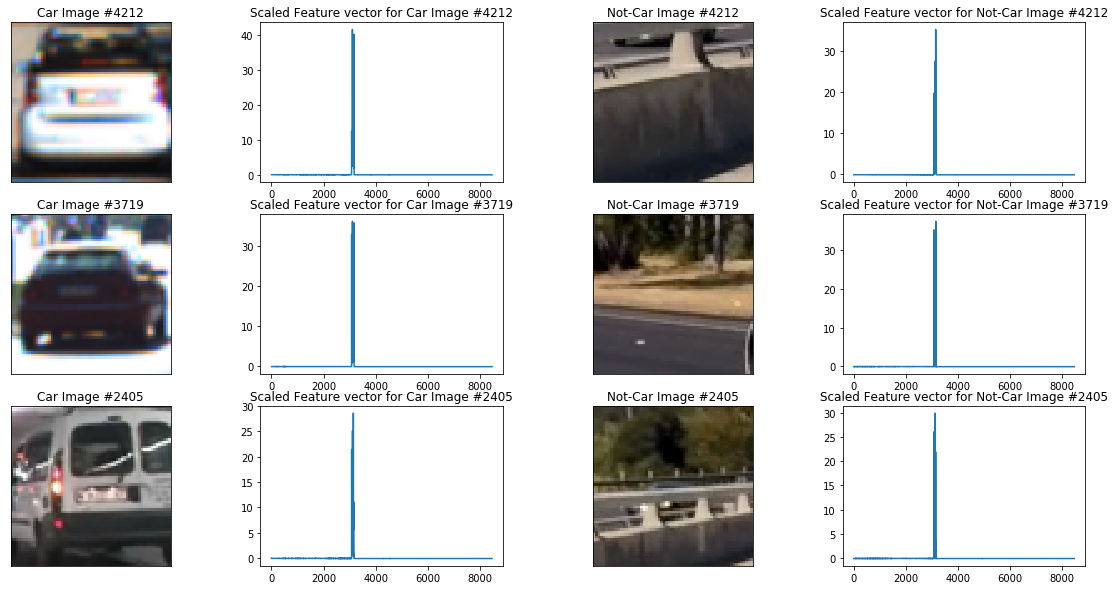

In [14]:
f, axarr6 = plt.subplots(nSamples,4,figsize=(20, 10))
for i in range(nSamples):
    
    X_scaler1 = StandardScaler().fit(cars_feature_vector_list[i].reshape(-1,1))
    # Apply the scaler to X
    scaled_X1 = X_scaler1.transform(cars_feature_vector_list[i].reshape(-1,1))

    X_scaler2 = StandardScaler().fit(notcars_feature_vector_list[i].reshape(-1,1))
    # Apply the scaler to X
    scaled_X2 = X_scaler2.transform(notcars_feature_vector_list[i].reshape(-1,1))

    axarr6[i,0].imshow(cars[samples[i]])
    axarr6[i,1].plot(range(len(scaled_X1)),scaled_X1)
    axarr6[i,2].imshow(notcars[samples[i]])
    axarr6[i,3].plot(range(len(scaled_X2)),scaled_X2)

    axarr6[i,0].set_xticks([])
    axarr6[i,0].set_yticks([])        
    axarr6[i,0].set_title("Car Image #" + str(samples[i]))
    axarr6[i,1].set_title("Scaled Feature vector for Car Image #" + str(samples[i]))
    axarr6[i,2].set_xticks([])
    axarr6[i,2].set_yticks([])            
    axarr6[i,2].set_title("Not-Car Image #" + str(samples[i]))
    axarr6[i,3].set_title("Scaled Feature vector for Not-Car Image #" + str(samples[i]))  

## Step 4: Supervised Learning: Support Vector Machine
The test car and not-car images were loaded and split into a training and testing dataset. 20% of the total dataset was chosen randomly as the testing dataset. The parameters used to extract the feature vector from the raw images are listed below.

In [15]:
cspace= 'YCrCb'#'HSV'#
orient = 9
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32)
nbins = 32
spatial_feat = True
hist_feat = True
hog_feat = True

In [16]:
loadMat = True

if not loadMat:
    car_features = []
    for i in range(len(cars)):
        if cspace == 'YCrCb':
            features = single_img_features(cars[i], color_space=cspace, spatial_size=spatial_size,
                                           hist_bins=nbins, orient=orient, pix_per_cell=pix_per_cell,
                                           cell_per_block=cell_per_block, hog_channel=hog_channel,
                                           spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)        
        else:
            features = single_img_features(cars[i]*255.0, color_space=cspace, spatial_size=spatial_size,
                                           hist_bins=nbins, orient=orient, pix_per_cell=pix_per_cell,
                                           cell_per_block=cell_per_block, hog_channel=hog_channel,
                                           spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
        if i == 0:
            car_features = np.array(features)
        else:
            car_features = np.vstack((car_features,features))
        
    print(car_features.shape)

In [17]:
if not loadMat:
    notcar_features = []
    for i in range(len(notcars)):
        if cspace == 'YCrCb':
            features = single_img_features(notcars[i], color_space=cspace, spatial_size=spatial_size,
                                        hist_bins=nbins, orient=orient, pix_per_cell=pix_per_cell,
                                        cell_per_block=cell_per_block, hog_channel=hog_channel,
                                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)    
        else:
            features = single_img_features(notcars[i]*255.0, color_space=cspace, spatial_size=spatial_size,
                                        hist_bins=nbins, orient=orient, pix_per_cell=pix_per_cell,
                                        cell_per_block=cell_per_block, hog_channel=hog_channel,
                                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
        if i == 0:
            notcar_features = np.array(features)
        else:
            notcar_features = np.vstack((notcar_features,features))
    print(notcar_features.shape)

## Save the feature vector for future use, so you dont have to load it again

In [18]:
import scipy.io as sio
if not loadMat:
    sio.savemat('featureVector.mat', {'car_features':car_features, 'notcar_features':notcar_features})
else:
    data = sio.loadmat('featureVector.mat')
    car_features = data['car_features']
    notcar_features = data['notcar_features']    
    print(car_features.shape)  
    print(notcar_features.shape)   

(8792, 8460)
(8968, 8460)


A standard scaler fit was applied to the feature vector to normalize the features.

In [19]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)#.reshape(-1,1)
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [20]:
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
print('Training data size: ', len(X_train))
print('Test data size: ', len(X_test))

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
Training data size:  14208
Test data size:  3552


## Step 4a: Testing out different parametes of the Support Vector Machine classifier
The C parameter of the Linear SVC was varied from 0.1 to 4 to compare training time and accuracy. It was found that accuracy was not affected by choice of C, while a higher C value lead to faster training time.

In [21]:
# # Use a linear SVC 
# c_param = [0.1,0.4,0.7,1,2,3,4]
# for c in c_param:
#     svc = LinearSVC(C = c)
# #     print(svc)
#     # Check the training time for the SVC
#     t=time.time()
#     svc.fit(X_train, y_train)
#     t2 = time.time()
#     print(round(t2-t, 2), 'Seconds to train SVC...')
#     # Check the score of the SVC
#     print('Test Accuracy of SVC with C = ', c ,' is: ', round(svc.score(X_test, y_test), 4))
#     # Check the prediction time for a single sample
#     t=time.time()
#     pred_index = np.random.randint(0, len(X_test)-1)
#     y_pred = svc.predict(X_test[pred_index,:])
#     print("Prediction: ", y_pred)
#     print("Actual: ", y_test[pred_index])  
#     t2 = time.time()
#     print(round(t2-t, 2), 'Seconds to predict SVC...')    
#     print()
#     svc = None

## Step-4b: Classification with the best parameters
The best C parameter was found to be 4 since it resulted in the fastest training time.

In [22]:
svc = LinearSVC(C = 4)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

14.91 Seconds to train SVC...
Test Accuracy of SVC =  0.991


## Step-4c: Confidence Score of predictions

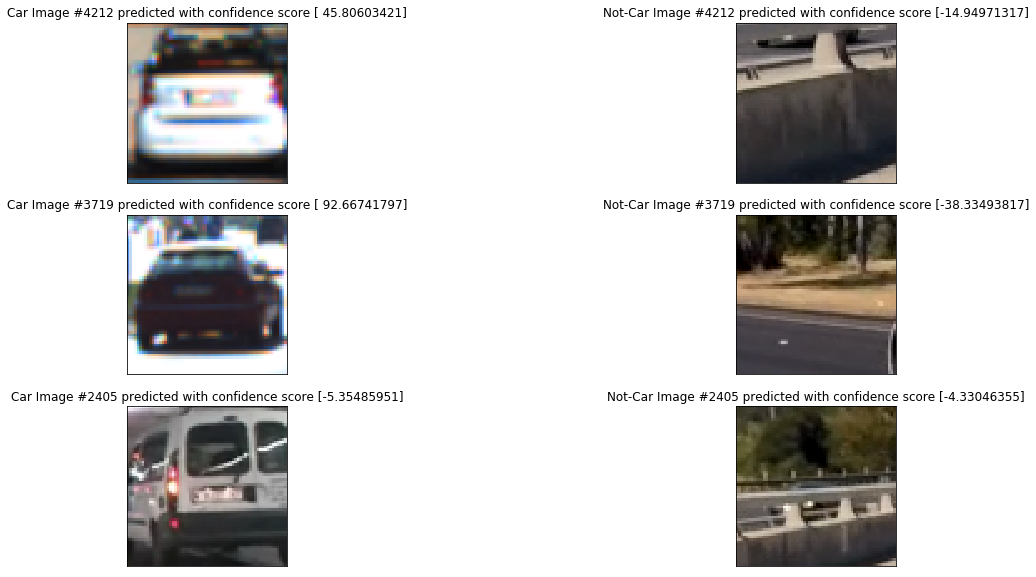

In [23]:
f, axarr7 = plt.subplots(nSamples,2,figsize=(20, 10))
for i in range(nSamples):
    axarr7[i,0].imshow(cars[samples[i]])
    axarr7[i,1].imshow(notcars[samples[i]])

    axarr7[i,0].set_xticks([])
    axarr7[i,0].set_yticks([])        
    axarr7[i,0].set_title("Car Image #" + str(samples[i]) + " predicted with confidence score " + \
                          str(svc.decision_function(cars_feature_vector_list[i])))
    axarr7[i,1].set_xticks([])
    axarr7[i,1].set_yticks([])        
    axarr7[i,1].set_title("Not-Car Image #" + str(samples[i]) + " predicted with confidence score " + \
                          str(svc.decision_function(notcars_feature_vector_list[i])))

## Step 5: Search Windows
Now that the classifier is trained on 64x64 images of cars and not-cars, the dashcam image is "windowed" with each window being passed through the classifier. 

In [24]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(image_shape, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = image_shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = image_shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def average_slide_windows(image_shape, x_start_stop=[None, None], y_start_stop=[None, None], xy_overlap=(0.5, 0.5)):
    windows = []
    for xy in [64, 96, 140]:
#     for xy in [60,100,200]:
        window = slide_window(image_shape, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=(xy, xy), xy_overlap=xy_overlap)
        windows += window
    return windows

In [25]:
image = mpimg.imread('/Users/chansek/Documents/GitHub/Self-Driving-Car/data/Dashcam/bbox-example-image.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255

# Min and max in y to search in slide_window()
y_start_stop = (450,720)
xy_overlap = (0.8,0.8)

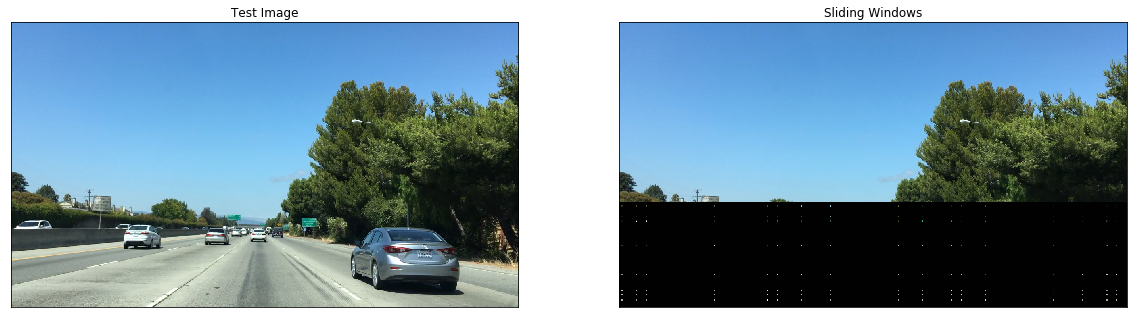

In [26]:
f, axf = plt.subplots(1,2,figsize=(20, 10))

all_windows = []
window_img = np.copy(image)

axf[0].imshow(window_img)

for i in range(1):#len(y_start_stop)):
#     windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop[i], 
#                         xy_window=xy_window[i], xy_overlap=xy_overlap[i])
    windows = average_slide_windows(image.shape, x_start_stop=[None, None], y_start_stop=y_start_stop,
                                    xy_overlap=xy_overlap)
    all_windows += windows

window_img = draw_boxes(window_img, windows, color=(0,255,0), thick=6)

axf[1].imshow(window_img)

axf[0].set_xticks([])
axf[0].set_yticks([])            
axf[0].set_title("Test Image")

axf[1].set_xticks([])
axf[1].set_yticks([])            
axf[1].set_title("Sliding Windows")

## Step 5b: Search windows with the trained classifier
Each window in the above plot is then searched using the classifier trained in Step-4. The classifier is probably going to give some false positives. To eliminate false positives, we get the heatmap from the classification and apply thresholding to the heatmap. The thresholded image is then labeled to identify the different cars in the entire image.

In [27]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    heatmap_thresh = np.copy(heatmap)
    # Zero out pixels below the threshold
    heatmap_thresh[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap_thresh

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0, 25, 255), 6)
    # Return the image
    return img

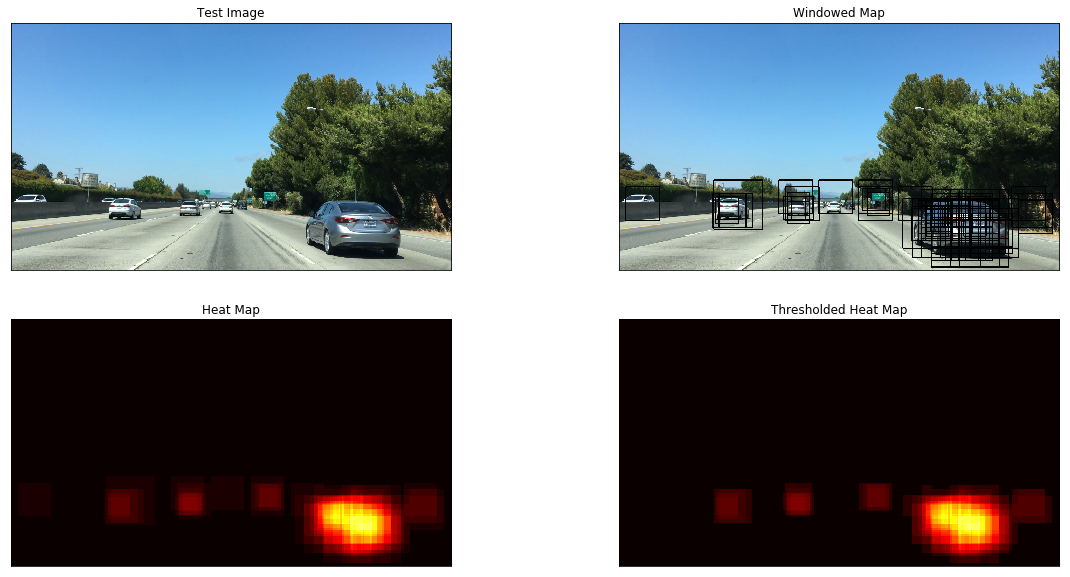

In [28]:
hot_windows = search_windows(image, all_windows, svc, X_scaler, color_space=cspace, 
                        spatial_size=spatial_size, hist_bins=nbins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=2)                    

heatmap = np.zeros_like(window_img[:,:,0]).astype(np.int)#float)

heatmap = add_heat(heatmap, hot_windows)
heatmap_thresh = apply_threshold(heatmap, 1)
heatmap_thresh = np.clip(heatmap_thresh, 0, 255)
f, axf = plt.subplots(2,2,figsize=(20, 10))
axf[0,0].imshow(image)
axf[0,1].imshow(window_img)
axf[1,0].imshow(heatmap, cmap = 'hot')
axf[1,1].imshow(heatmap_thresh, cmap = 'hot')

axf[0,0].set_xticks([])
axf[0,0].set_yticks([])            
axf[0,0].set_title("Test Image")

axf[0,1].set_xticks([])
axf[0,1].set_yticks([])            
axf[0,1].set_title("Windowed Map")

axf[1,0].set_xticks([])
axf[1,0].set_yticks([])            
axf[1,0].set_title("Heat Map")

axf[1,1].set_xticks([])
axf[1,1].set_yticks([])            
axf[1,1].set_title("Thresholded Heat Map")

The thresholded heat map is then labeled and plotted. Notice there are still 2 false positives, one next to the closest car on the right and the other being a road sign.
These false positives can be eliminated through filtering by averaging over previous frames in a video.

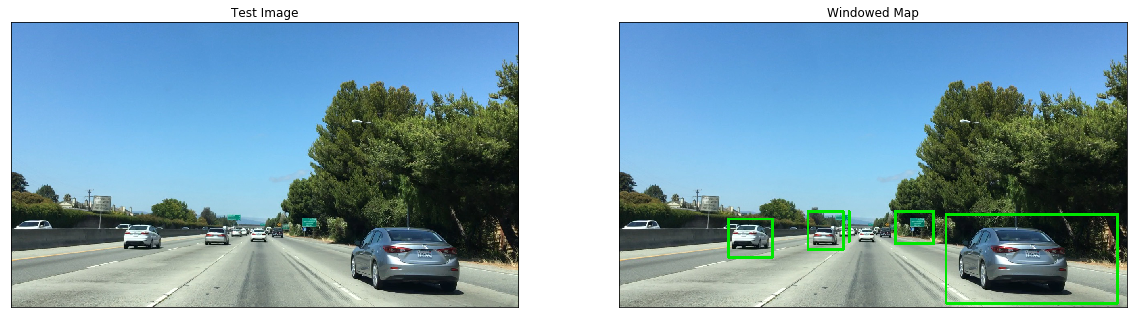

In [39]:
from scipy.ndimage.measurements import label
labels = label(heatmap_thresh)
# print(np.unique(labels[0]))
draw_image = np.copy(image)
applied_image = draw_labeled_bboxes(draw_image, labels)

f, axf = plt.subplots(1,2,figsize=(20, 10))
axf[0].imshow(image)
axf[1].imshow(applied_image)

axf[0].set_xticks([])
axf[0].set_yticks([])            
axf[0].set_title("Test Image")

axf[1].set_xticks([])
axf[1].set_yticks([])            
axf[1].set_title("Windowed Map")


## Step-6: Experiment on Test Images
Now that we have trial-and-tested the parameters for the vehicle detection algorithm, it is time to test the algorithm on test images.

In [ ]:
y_start_stop = (250,650)
xy_overlap = (0.8,0.8)
heat_threshold = 2

windows = average_slide_windows(image.shape, x_start_stop=[None, None],
                                y_start_stop=y_start_stop,xy_overlap=xy_overlap)

glob_test_images = glob.glob('./test_images/*.jpg')
f, ax = plt.subplots(len(glob_test_images), 4, figsize=(20,30))
imgNum = 0

for file in glob_test_images:
    image = mpimg.imread(file)
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255.0
    draw_image = np.copy(image)

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=cspace, 
                            spatial_size=spatial_size, hist_bins=nbins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)    

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
    heat = np.zeros_like(window_img[:,:,0]).astype(np.float)
    
    heatmap = add_heat(heat, hot_windows)
    heatmap_thresh = apply_threshold(heatmap, heat_threshold)

    labels = label(heatmap_thresh)
    applied_image = draw_labeled_bboxes(draw_image, labels)
    
    
    ax[imgNum,0].imshow(image)
    ax[imgNum,0].set_title('Window Image', fontsize=10)
    
    ax[imgNum,1].imshow(heatmap, cmap='hot')
    ax[imgNum,1].set_title('Heatmap Image', fontsize=10)
    
    ax[imgNum,2].imshow(heatmap_thresh, cmap='hot')
    ax[imgNum,2].set_title('Heatmap Image with {} cars found'.format(labels[1]), fontsize=10)
    
    ax[imgNum,3].imshow(applied_image)
    ax[imgNum,3].set_title('Annotated image', fontsize=10)
    
    imgNum = imgNum+1    

## Step-7: Hog Subsampling
The above algorithm is slow because of sequential windowing to identify and detect vehicles at different points in the image. A faster way would be to subsample hog features. This is similar to the above technique, but much faster.
Note that Steps 6 & 7 are applying different methods for the same images and the results are slightly different.

In [40]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, color_space=cspace, 
                            spatial_size=spatial_size, hist_bins=nbins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat) :
    
    draw_img = np.copy(img)     
    img = img.astype(np.float32)/255.0
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = change_cspace(img_tosearch,color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
 
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ctrans_tosearch, hog_channel = 0, orient = 9, pix_per_cell = 8, cell_per_block = 2,
                     vis=False, feature_vec=False)
    hog2 = get_hog_features(ctrans_tosearch, hog_channel = 0, orient = 9, pix_per_cell = 8, cell_per_block = 2,
                     vis=False, feature_vec=False)
    hog3 = get_hog_features(ctrans_tosearch, hog_channel = 0, orient = 9, pix_per_cell = 8, cell_per_block = 2,
                     vis=False, feature_vec=False)
    hot_windows = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    

            len1 = 0
            len2 = len(spatial_features)
            len3 = len(hist_features)
            len4 = len(spatial_features) + len(hist_features)

            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                hot_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return hot_windows

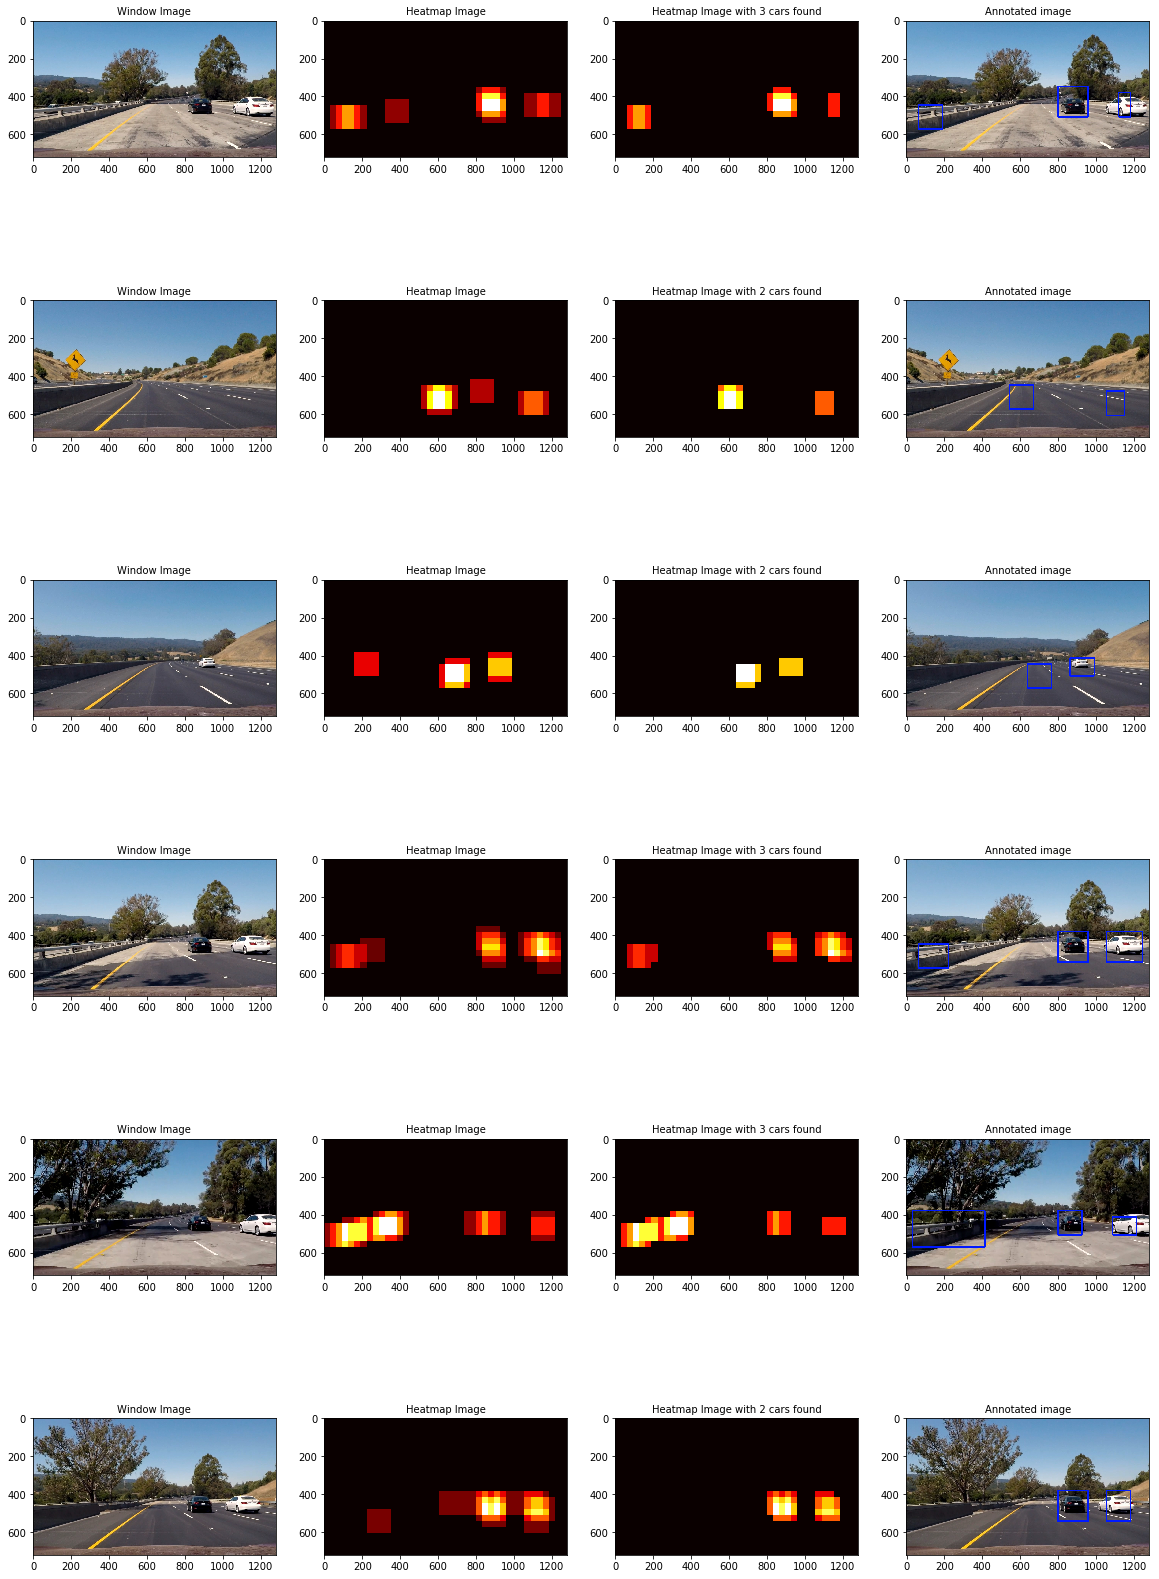

In [47]:
y_start_stop = (350,650)
heat_threshold = 1
scale = 2.0#1.75

glob_test_images = glob.glob('./test_images/*.jpg')
f, ax = plt.subplots(len(glob_test_images), 4, figsize=(20,30))
imgNum = 0

window_img = []
heatmap = []
heatmap_thresh = []
applied_image

for file in glob_test_images:
    image = mpimg.imread(file)
    draw_image = np.copy(image)    

    hot_windows = find_cars(image, y_start_stop[0], y_start_stop[1],scale,
                           svc, X_scaler, color_space=cspace, 
                            spatial_size=spatial_size, hist_bins=nbins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat) 
    
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
    heat = np.zeros_like(window_img[:,:,0]).astype(np.float)
    
    heatmap = add_heat(heat, hot_windows)
    heatmap_thresh = apply_threshold(heatmap, heat_threshold)
    heatmap_thresh = np.clip(heatmap_thresh, 0, 255)
    labels = label(heatmap_thresh)
    applied_image = draw_labeled_bboxes(draw_image, labels)
    
    
    ax[imgNum,0].imshow(image)
    ax[imgNum,0].set_title('Window Image', fontsize=10)
    
    ax[imgNum,1].imshow(heatmap, cmap='hot')
    ax[imgNum,1].set_title('Heatmap Image', fontsize=10)
    
    ax[imgNum,2].imshow(heatmap_thresh, cmap='hot')
    ax[imgNum,2].set_title('Heatmap Image with {} cars found'.format(labels[1]), fontsize=10)
    
    ax[imgNum,3].imshow(applied_image)
    ax[imgNum,3].set_title('Annotated image', fontsize=10)
    
    imgNum = imgNum+1   

## Step 8: Vehicle Detection Pipeline
Now that we have the algorithm and its parameters tuned, we are ready to write the pipeline.
In the pipeline, I have included some filtering and averaging to weed out the false positives more effectively.

In [90]:
from collections import deque
heat_prev = deque(maxlen = 1)
y_start_stop = (350,650)#(300,650)
heat_threshold = 3#3#2.5
scale = 2.0#1.75#0.95#1.75
    
def vehicle_detection_pipeline(image):
    draw_image = np.copy(image)

    hot_windows = find_cars(image, y_start_stop[0], y_start_stop[1],scale,
                           svc, X_scaler, color_space=cspace, 
                            spatial_size=spatial_size, hist_bins=nbins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat) 
    
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
    heat = np.zeros_like(window_img[:,:,0]).astype(np.float)
    heatmap = add_heat(heat, hot_windows)
    heat_prev.append(heatmap) 
    heatmap_thresh = np.zeros_like(heatmap)
    
    logical_ind = np.ones_like(heatmap)
#     logical_ind = np.zeros_like(heatmap)
    for i in range(len(heat_prev)-1,-1,-1):
        tmp = apply_threshold(heat_prev[i], heat_threshold)
        logical_ind = np.logical_and(tmp > 0,logical_ind)         
#         logical_ind = np.logical_or(tmp > 0,logical_ind) 

    
#     curr_heatmap_thresh = apply_threshold(heatmap, heat_threshold)
#     logical_ind = np.logical_and(curr_heatmap_thresh > 0,logical_ind)
    heatmap_thresh[logical_ind] = 1
# #     total_thresh = heatmap#np.zeros_like(heatmap)
# #     for i in heat_prev:
# #         ind = np.logical_and(total_thresh > 0,i > 0)
# #         print(ind)
# #         total_thresh[ind] += 1
# # #         total_thresh += i
#     print(total_thresh)   
#     total_thresh = heatmap
#     heatmap_thresh = apply_threshold(total_thresh, heat_threshold)        

    labels = label(heatmap_thresh)
    print(np.unique(labels[0]))
#     print(np.unique(labels))
    final_img = draw_labeled_bboxes(draw_image, labels)

    return final_img

[0 1]
[0 1]
[0]
[0 1 2]
[0 1 2]
[0 1 2]


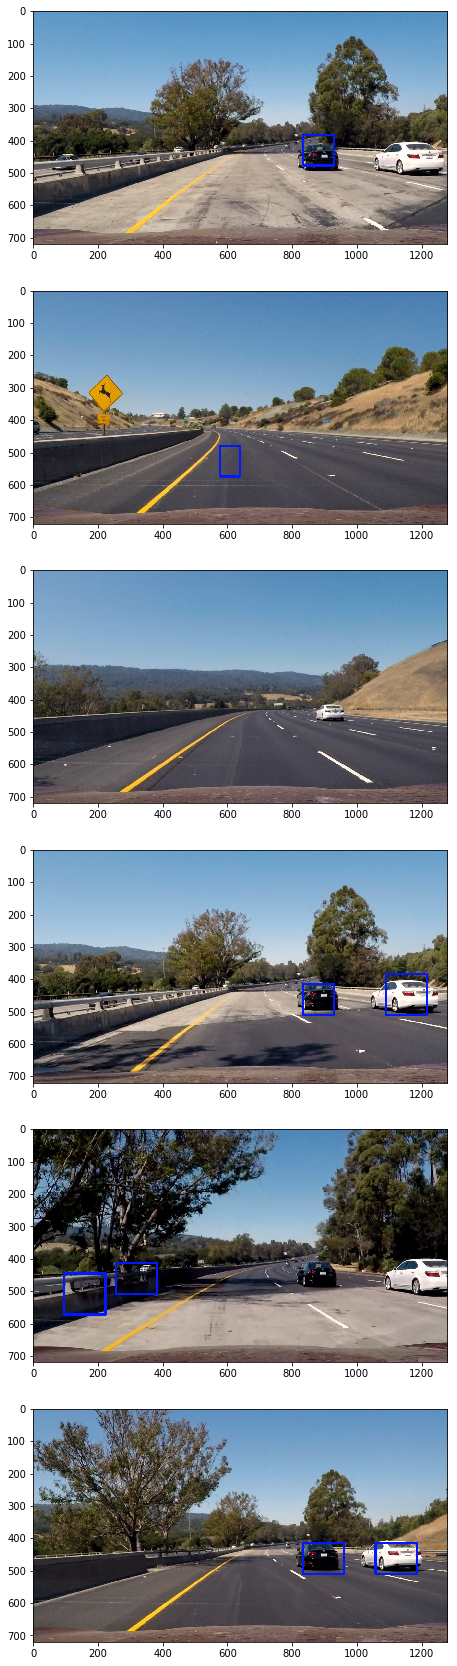

In [91]:
t=time.time()
f, ax = plt.subplots(len(glob_test_images), 1, figsize=(20,30))
for i in range(len(glob_test_images)):
    heat_prev = deque(maxlen = 1)
    image = mpimg.imread(glob_test_images[i])
    final_img = vehicle_detection_pipeline(image)
    ax[i].imshow(final_img)

In [94]:
heat_prev = None
heat_prev = deque(maxlen = 5)
heat_threshold = 2
print(heat_threshold)
challenge_output = 'test_video_output.mp4'
clip2 = VideoFileClip('test_video.mp4')
challenge_clip = clip2.fl_image(vehicle_detection_pipeline)
%time challenge_clip.write_videofile(challenge_output, audio=False)

1
[0 1 2]
[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4



  3%|▎         | 1/39 [00:01<00:44,  1.18s/it]

[0 1 2]



  5%|▌         | 2/39 [00:02<00:44,  1.20s/it]

[0 1 2]



  8%|▊         | 3/39 [00:03<00:45,  1.27s/it]

[0 1 2]



 10%|█         | 4/39 [00:05<00:44,  1.27s/it]

[0 1 2]



 13%|█▎        | 5/39 [00:06<00:43,  1.29s/it]

[0 1 2]



 15%|█▌        | 6/39 [00:07<00:42,  1.28s/it]

[0 1 2]



 18%|█▊        | 7/39 [00:08<00:40,  1.26s/it]

[0 1 2]



 21%|██        | 8/39 [00:10<00:39,  1.27s/it]

[0 1 2]



 23%|██▎       | 9/39 [00:11<00:38,  1.27s/it]

[0 1]



 26%|██▌       | 10/39 [00:12<00:37,  1.28s/it]

[0 1]



 28%|██▊       | 11/39 [00:14<00:35,  1.26s/it]

[0 1]



 31%|███       | 12/39 [00:15<00:33,  1.23s/it]

[0 1]



 33%|███▎      | 13/39 [00:16<00:31,  1.21s/it]

[0 1 2]



 36%|███▌      | 14/39 [00:17<00:30,  1.23s/it]

[0 1 2 3]



 38%|███▊      | 15/39 [00:18<00:30,  1.26s/it]

[0 1 2]



 41%|████      | 16/39 [00:20<00:28,  1.25s/it]

[0 1 2]



 44%|████▎     | 17/39 [00:21<00:27,  1.24s/it]

[0 1 2]



 46%|████▌     | 18/39 [00:22<00:25,  1.22s/it]

[0 1 2]



 49%|████▊     | 19/39 [00:23<00:23,  1.20s/it]

[0 1 2]



 51%|█████▏    | 20/39 [00:24<00:22,  1.19s/it]

[0 1 2]



 54%|█████▍    | 21/39 [00:26<00:21,  1.17s/it]

[0 1 2]



 56%|█████▋    | 22/39 [00:27<00:19,  1.17s/it]

[0 1 2]



 59%|█████▉    | 23/39 [00:28<00:18,  1.16s/it]

[0 1 2]



 62%|██████▏   | 24/39 [00:29<00:17,  1.17s/it]

[0 1 2]



 64%|██████▍   | 25/39 [00:30<00:16,  1.17s/it]

[0 1 2]



 67%|██████▋   | 26/39 [00:31<00:15,  1.16s/it]

[0 1 2]



 69%|██████▉   | 27/39 [00:32<00:13,  1.15s/it]

[0 1 2]



 72%|███████▏  | 28/39 [00:34<00:12,  1.14s/it]

[0 1 2]



 74%|███████▍  | 29/39 [00:35<00:11,  1.14s/it]

[0 1 2]



 77%|███████▋  | 30/39 [00:36<00:10,  1.13s/it]

[0 1 2 3]



 79%|███████▉  | 31/39 [00:37<00:08,  1.12s/it]

[0 1 2 3]



 82%|████████▏ | 32/39 [00:38<00:07,  1.13s/it]

[0 1 2 3]



 85%|████████▍ | 33/39 [00:39<00:06,  1.15s/it]

[0 1 2 3]



 87%|████████▋ | 34/39 [00:40<00:05,  1.15s/it]

[0 1 2 3]



 90%|████████▉ | 35/39 [00:42<00:04,  1.14s/it]

[0 1 2 3]



 92%|█████████▏| 36/39 [00:43<00:03,  1.13s/it]

[0 1 2 3]



 95%|█████████▍| 37/39 [00:44<00:02,  1.14s/it]

[0 1 2]



 97%|█████████▋| 38/39 [00:45<00:01,  1.13s/it]

[0 1]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

CPU times: user 43.3 s, sys: 2.67 s, total: 46 s
Wall time: 46.7 s


## Test on the project video

In [97]:
heat_prev = None
heat_prev = deque(maxlen = 5)
heat_threshold = 2
project_output = 'project_video_output_test1.mp4'
clip2 = VideoFileClip('project_video.mp4').subclip(0,10)# 15)
challenge_clip = clip2.fl_image(vehicle_detection_pipeline)
%time challenge_clip.write_videofile(project_output, audio=False)

[0]
[MoviePy] >>>> Building video project_video_output_test1.mp4
[MoviePy] Writing video project_video_output_test1.mp4



  0%|          | 1/251 [00:01<04:49,  1.16s/it]

[0]



  1%|          | 2/251 [00:02<04:52,  1.18s/it]

[0]



  1%|          | 3/251 [00:03<04:51,  1.17s/it]

[0]



  2%|▏         | 4/251 [00:04<04:49,  1.17s/it]

[0]



  2%|▏         | 5/251 [00:05<04:46,  1.16s/it]

[0]



  2%|▏         | 6/251 [00:07<04:44,  1.16s/it]

[0]



  3%|▎         | 7/251 [00:08<04:41,  1.15s/it]

[0]



  3%|▎         | 8/251 [00:09<04:44,  1.17s/it]

[0]



  4%|▎         | 9/251 [00:10<04:42,  1.17s/it]

[0]



  4%|▍         | 10/251 [00:11<04:39,  1.16s/it]

[0]



  4%|▍         | 11/251 [00:12<04:38,  1.16s/it]

[0]



  5%|▍         | 12/251 [00:13<04:35,  1.15s/it]

[0]



  5%|▌         | 13/251 [00:15<04:34,  1.15s/it]

[0]



  6%|▌         | 14/251 [00:16<04:31,  1.15s/it]

[0]



  6%|▌         | 15/251 [00:17<04:29,  1.14s/it]

[0]



  6%|▋         | 16/251 [00:18<04:27,  1.14s/it]

[0]



  7%|▋         | 17/251 [00:19<04:27,  1.14s/it]

[0]



  7%|▋         | 18/251 [00:20<04:33,  1.17s/it]

[0]



  8%|▊         | 19/251 [00:22<04:39,  1.21s/it]

[0]



  8%|▊         | 20/251 [00:23<04:39,  1.21s/it]

[0]



  8%|▊         | 21/251 [00:24<04:32,  1.19s/it]

[0]



  9%|▉         | 22/251 [00:25<04:27,  1.17s/it]

[0]



  9%|▉         | 23/251 [00:26<04:24,  1.16s/it]

[0]



 10%|▉         | 24/251 [00:27<04:24,  1.17s/it]

[0]



 10%|▉         | 25/251 [00:29<04:27,  1.18s/it]

[0]



 10%|█         | 26/251 [00:30<04:24,  1.18s/it]

[0]



 11%|█         | 27/251 [00:31<04:21,  1.17s/it]

[0]



 11%|█         | 28/251 [00:32<04:18,  1.16s/it]

[0]



 12%|█▏        | 29/251 [00:33<04:14,  1.15s/it]

[0]



 12%|█▏        | 30/251 [00:34<04:11,  1.14s/it]

[0]



 12%|█▏        | 31/251 [00:36<04:10,  1.14s/it]

[0]



 13%|█▎        | 32/251 [00:37<04:08,  1.14s/it]

[0]



 13%|█▎        | 33/251 [00:38<04:07,  1.13s/it]

[0]



 14%|█▎        | 34/251 [00:39<04:05,  1.13s/it]

[0]



 14%|█▍        | 35/251 [00:40<04:04,  1.13s/it]

[0]



 14%|█▍        | 36/251 [00:41<04:04,  1.14s/it]

[0]



 15%|█▍        | 37/251 [00:42<04:05,  1.15s/it]

[0]



 15%|█▌        | 38/251 [00:43<04:02,  1.14s/it]

[0]



 16%|█▌        | 39/251 [00:45<04:01,  1.14s/it]

[0]



 16%|█▌        | 40/251 [00:46<03:59,  1.14s/it]

[0]



 16%|█▋        | 41/251 [00:47<03:57,  1.13s/it]

[0]



 17%|█▋        | 42/251 [00:48<03:55,  1.13s/it]

[0]



 17%|█▋        | 43/251 [00:49<03:55,  1.13s/it]

[0]



 18%|█▊        | 44/251 [00:50<03:57,  1.15s/it]

[0]



 18%|█▊        | 45/251 [00:51<03:56,  1.15s/it]

[0]



 18%|█▊        | 46/251 [00:53<03:53,  1.14s/it]

[0]



 19%|█▊        | 47/251 [00:54<03:51,  1.14s/it]

[0]



 19%|█▉        | 48/251 [00:55<03:49,  1.13s/it]

[0]



 20%|█▉        | 49/251 [00:56<03:48,  1.13s/it]

[0]



 20%|█▉        | 50/251 [00:57<03:46,  1.13s/it]

[0]



 20%|██        | 51/251 [00:58<03:44,  1.12s/it]

[0]



 21%|██        | 52/251 [00:59<03:46,  1.14s/it]

[0]



 21%|██        | 53/251 [01:01<03:48,  1.15s/it]

[0]



 22%|██▏       | 54/251 [01:02<03:45,  1.14s/it]

[0]



 22%|██▏       | 55/251 [01:03<03:44,  1.14s/it]

[0]



 22%|██▏       | 56/251 [01:04<03:43,  1.14s/it]

[0]



 23%|██▎       | 57/251 [01:05<03:40,  1.14s/it]

[0]



 23%|██▎       | 58/251 [01:06<03:40,  1.14s/it]

[0]



 24%|██▎       | 59/251 [01:07<03:40,  1.15s/it]

[0]



 24%|██▍       | 60/251 [01:09<03:36,  1.13s/it]

[0]



 24%|██▍       | 61/251 [01:10<03:37,  1.14s/it]

[0]



 25%|██▍       | 62/251 [01:11<03:36,  1.14s/it]

[0]



 25%|██▌       | 63/251 [01:12<03:34,  1.14s/it]

[0]



 25%|██▌       | 64/251 [01:13<03:33,  1.14s/it]

[0]



 26%|██▌       | 65/251 [01:14<03:32,  1.14s/it]

[0]



 26%|██▋       | 66/251 [01:15<03:29,  1.13s/it]

[0]



 27%|██▋       | 67/251 [01:16<03:28,  1.13s/it]

[0]



 27%|██▋       | 68/251 [01:18<03:27,  1.13s/it]

[0]



 27%|██▋       | 69/251 [01:19<03:25,  1.13s/it]

[0]



 28%|██▊       | 70/251 [01:20<03:26,  1.14s/it]

[0]



 28%|██▊       | 71/251 [01:21<03:26,  1.15s/it]

[0]



 29%|██▊       | 72/251 [01:22<03:24,  1.14s/it]

[0]



 29%|██▉       | 73/251 [01:23<03:24,  1.15s/it]

[0]



 29%|██▉       | 74/251 [01:24<03:21,  1.14s/it]

[0]



 30%|██▉       | 75/251 [01:26<03:19,  1.13s/it]

[0]



 30%|███       | 76/251 [01:27<03:17,  1.13s/it]

[0]



 31%|███       | 77/251 [01:28<03:15,  1.12s/it]

[0]



 31%|███       | 78/251 [01:29<03:14,  1.13s/it]

[0]



 31%|███▏      | 79/251 [01:30<03:15,  1.14s/it]

[0]



 32%|███▏      | 80/251 [01:31<03:14,  1.14s/it]

[0]



 32%|███▏      | 81/251 [01:32<03:13,  1.14s/it]

[0]



 33%|███▎      | 82/251 [01:34<03:14,  1.15s/it]

[0]



 33%|███▎      | 83/251 [01:35<03:11,  1.14s/it]

[0]



 33%|███▎      | 84/251 [01:36<03:10,  1.14s/it]

[0]



 34%|███▍      | 85/251 [01:37<03:08,  1.14s/it]

[0]



 34%|███▍      | 86/251 [01:38<03:08,  1.15s/it]

[0]



 35%|███▍      | 87/251 [01:39<03:08,  1.15s/it]

[0]



 35%|███▌      | 88/251 [01:40<03:07,  1.15s/it]

[0]



 35%|███▌      | 89/251 [01:42<03:05,  1.15s/it]

[0]



 36%|███▌      | 90/251 [01:43<03:04,  1.15s/it]

[0]



 36%|███▋      | 91/251 [01:44<03:02,  1.14s/it]

[0]



 37%|███▋      | 92/251 [01:45<03:00,  1.14s/it]

[0]



 37%|███▋      | 93/251 [01:46<03:00,  1.14s/it]

[0]



 37%|███▋      | 94/251 [01:47<02:57,  1.13s/it]

[0]



 38%|███▊      | 95/251 [01:48<02:56,  1.13s/it]

[0]



 38%|███▊      | 96/251 [01:50<02:56,  1.14s/it]

[0]



 39%|███▊      | 97/251 [01:51<02:55,  1.14s/it]

[0]



 39%|███▉      | 98/251 [01:52<02:55,  1.14s/it]

[0]



 39%|███▉      | 99/251 [01:53<02:53,  1.14s/it]

[0]



 40%|███▉      | 100/251 [01:54<02:50,  1.13s/it]

[0]



 40%|████      | 101/251 [01:55<02:49,  1.13s/it]

[0]



 41%|████      | 102/251 [01:56<02:49,  1.14s/it]

[0]



 41%|████      | 103/251 [01:57<02:48,  1.14s/it]

[0]



 41%|████▏     | 104/251 [01:59<02:48,  1.15s/it]

[0]



 42%|████▏     | 105/251 [02:00<02:47,  1.15s/it]

[0]



 42%|████▏     | 106/251 [02:01<02:45,  1.14s/it]

[0]



 43%|████▎     | 107/251 [02:02<02:44,  1.14s/it]

[0]



 43%|████▎     | 108/251 [02:03<02:43,  1.14s/it]

[0]



 43%|████▎     | 109/251 [02:04<02:43,  1.15s/it]

[0]



 44%|████▍     | 110/251 [02:05<02:40,  1.14s/it]

[0]



 44%|████▍     | 111/251 [02:07<02:38,  1.13s/it]

[0]



 45%|████▍     | 112/251 [02:08<02:36,  1.13s/it]

[0]



 45%|████▌     | 113/251 [02:09<02:37,  1.14s/it]

[0]



 45%|████▌     | 114/251 [02:10<02:39,  1.16s/it]

[0]



 46%|████▌     | 115/251 [02:12<02:51,  1.26s/it]

[0]



 46%|████▌     | 116/251 [02:13<02:55,  1.30s/it]

[0]



 47%|████▋     | 117/251 [02:14<02:58,  1.33s/it]

[0]



 47%|████▋     | 118/251 [02:16<02:59,  1.35s/it]

[0]



 47%|████▋     | 119/251 [02:17<02:59,  1.36s/it]

[0]



 48%|████▊     | 120/251 [02:19<02:58,  1.36s/it]

[0]



 48%|████▊     | 121/251 [02:20<02:58,  1.37s/it]

[0]



 49%|████▊     | 122/251 [02:21<02:56,  1.37s/it]

[0]



 49%|████▉     | 123/251 [02:23<02:57,  1.39s/it]

[0]



 49%|████▉     | 124/251 [02:24<02:53,  1.37s/it]

[0]



 50%|████▉     | 125/251 [02:26<02:58,  1.42s/it]

[0]



 50%|█████     | 126/251 [02:27<02:54,  1.39s/it]

[0]



 51%|█████     | 127/251 [02:29<03:02,  1.47s/it]

[0]



 51%|█████     | 128/251 [02:30<02:55,  1.43s/it]

[0]



 51%|█████▏    | 129/251 [02:31<02:50,  1.40s/it]

[0]



 52%|█████▏    | 130/251 [02:33<02:48,  1.39s/it]

[0]



 52%|█████▏    | 131/251 [02:34<02:42,  1.35s/it]

[0]



 53%|█████▎    | 132/251 [02:35<02:39,  1.34s/it]

[0]



 53%|█████▎    | 133/251 [02:36<02:35,  1.32s/it]

[0]



 53%|█████▎    | 134/251 [02:38<02:35,  1.33s/it]

[0]



 54%|█████▍    | 135/251 [02:39<02:29,  1.29s/it]

[0]



 54%|█████▍    | 136/251 [02:40<02:22,  1.24s/it]

[0]



 55%|█████▍    | 137/251 [02:41<02:25,  1.27s/it]

[0]



 55%|█████▍    | 138/251 [02:43<02:26,  1.29s/it]

[0]



 55%|█████▌    | 139/251 [02:44<02:23,  1.28s/it]

[0]



 56%|█████▌    | 140/251 [02:45<02:18,  1.25s/it]

[0]



 56%|█████▌    | 141/251 [02:46<02:12,  1.21s/it]

[0]



 57%|█████▋    | 142/251 [02:48<02:10,  1.20s/it]

[0]



 57%|█████▋    | 143/251 [02:49<02:08,  1.19s/it]

[0]



 57%|█████▋    | 144/251 [02:50<02:04,  1.17s/it]

[0]



 58%|█████▊    | 145/251 [02:51<02:03,  1.17s/it]

[0]



 58%|█████▊    | 146/251 [02:52<02:00,  1.15s/it]

[0]



 59%|█████▊    | 147/251 [02:53<01:59,  1.15s/it]

[0]



 59%|█████▉    | 148/251 [02:54<01:59,  1.16s/it]

[0]



 59%|█████▉    | 149/251 [02:56<01:59,  1.18s/it]

[0]



 60%|█████▉    | 150/251 [02:57<02:04,  1.23s/it]

[0]



 60%|██████    | 151/251 [02:58<02:09,  1.29s/it]

[0]



 61%|██████    | 152/251 [03:00<02:05,  1.27s/it]

[0]



 61%|██████    | 153/251 [03:01<02:11,  1.34s/it]

[0]



 61%|██████▏   | 154/251 [03:03<02:12,  1.37s/it]

[0]



 62%|██████▏   | 155/251 [03:04<02:10,  1.36s/it]

[0]



 62%|██████▏   | 156/251 [03:05<02:07,  1.34s/it]

[0]



 63%|██████▎   | 157/251 [03:06<02:00,  1.28s/it]

[0]



 63%|██████▎   | 158/251 [03:08<01:55,  1.24s/it]

[0]



 63%|██████▎   | 159/251 [03:09<01:51,  1.21s/it]

[0]



 64%|██████▎   | 160/251 [03:10<01:48,  1.19s/it]

[0]



 64%|██████▍   | 161/251 [03:11<01:46,  1.18s/it]

[0]



 65%|██████▍   | 162/251 [03:12<01:45,  1.18s/it]

[0]



 65%|██████▍   | 163/251 [03:13<01:47,  1.22s/it]

[0]



 65%|██████▌   | 164/251 [03:15<01:44,  1.20s/it]

[0]



 66%|██████▌   | 165/251 [03:16<01:41,  1.18s/it]

[0]



 66%|██████▌   | 166/251 [03:17<01:45,  1.24s/it]

[0]



 67%|██████▋   | 167/251 [03:18<01:41,  1.21s/it]

[0]



 67%|██████▋   | 168/251 [03:20<01:42,  1.23s/it]

[0]



 67%|██████▋   | 169/251 [03:21<01:47,  1.31s/it]

[0]



 68%|██████▊   | 170/251 [03:23<01:51,  1.37s/it]

[0]



 68%|██████▊   | 171/251 [03:24<01:47,  1.35s/it]

[0]



 69%|██████▊   | 172/251 [03:25<01:45,  1.33s/it]

[0]



 69%|██████▉   | 173/251 [03:26<01:40,  1.29s/it]

[0]



 69%|██████▉   | 174/251 [03:27<01:36,  1.25s/it]

[0 1]



 70%|██████▉   | 175/251 [03:29<01:32,  1.22s/it]

[0 1]



 70%|███████   | 176/251 [03:30<01:30,  1.21s/it]

[0 1]



 71%|███████   | 177/251 [03:31<01:27,  1.19s/it]

[0 1]



 71%|███████   | 178/251 [03:32<01:25,  1.17s/it]

[0 1]



 71%|███████▏  | 179/251 [03:33<01:23,  1.16s/it]

[0 1]



 72%|███████▏  | 180/251 [03:34<01:22,  1.16s/it]

[0 1]



 72%|███████▏  | 181/251 [03:36<01:20,  1.15s/it]

[0 1]



 73%|███████▎  | 182/251 [03:37<01:19,  1.16s/it]

[0 1]



 73%|███████▎  | 183/251 [03:38<01:18,  1.15s/it]

[0 1]



 73%|███████▎  | 184/251 [03:39<01:16,  1.14s/it]

[0 1]



 74%|███████▎  | 185/251 [03:40<01:15,  1.14s/it]

[0 1]



 74%|███████▍  | 186/251 [03:41<01:14,  1.15s/it]

[0 1]



 75%|███████▍  | 187/251 [03:42<01:13,  1.15s/it]

[0 1]



 75%|███████▍  | 188/251 [03:44<01:11,  1.14s/it]

[0 1]



 75%|███████▌  | 189/251 [03:45<01:10,  1.14s/it]

[0 1]



 76%|███████▌  | 190/251 [03:46<01:09,  1.15s/it]

[0 1]



 76%|███████▌  | 191/251 [03:47<01:09,  1.15s/it]

[0 1]



 76%|███████▋  | 192/251 [03:48<01:07,  1.14s/it]

[0 1]



 77%|███████▋  | 193/251 [03:49<01:06,  1.14s/it]

[0 1]



 77%|███████▋  | 194/251 [03:50<01:05,  1.14s/it]

[0 1 2]



 78%|███████▊  | 195/251 [03:52<01:04,  1.15s/it]

[0 1 2]



 78%|███████▊  | 196/251 [03:53<01:02,  1.14s/it]

[0 1]



 78%|███████▊  | 197/251 [03:54<01:01,  1.15s/it]

[0 1]



 79%|███████▉  | 198/251 [03:55<01:01,  1.16s/it]

[0 1]



 79%|███████▉  | 199/251 [03:56<01:00,  1.16s/it]

[0 1]



 80%|███████▉  | 200/251 [03:57<00:58,  1.15s/it]

[0 1]



 80%|████████  | 201/251 [03:58<00:57,  1.14s/it]

[0 1]



 80%|████████  | 202/251 [04:00<00:55,  1.14s/it]

[0 1]



 81%|████████  | 203/251 [04:01<00:54,  1.13s/it]

[0 1]



 81%|████████▏ | 204/251 [04:02<00:53,  1.13s/it]

[0 1]



 82%|████████▏ | 205/251 [04:03<00:51,  1.13s/it]

[0 1]



 82%|████████▏ | 206/251 [04:04<00:51,  1.14s/it]

[0 1]



 82%|████████▏ | 207/251 [04:05<00:50,  1.15s/it]

[0 1]



 83%|████████▎ | 208/251 [04:06<00:49,  1.15s/it]

[0 1]



 83%|████████▎ | 209/251 [04:08<00:47,  1.14s/it]

[0 1]



 84%|████████▎ | 210/251 [04:09<00:46,  1.13s/it]

[0 1]



 84%|████████▍ | 211/251 [04:10<00:45,  1.13s/it]

[0 1]



 84%|████████▍ | 212/251 [04:11<00:44,  1.13s/it]

[0]



 85%|████████▍ | 213/251 [04:12<00:42,  1.13s/it]

[0]



 85%|████████▌ | 214/251 [04:13<00:41,  1.12s/it]

[0]



 86%|████████▌ | 215/251 [04:14<00:40,  1.11s/it]

[0]



 86%|████████▌ | 216/251 [04:15<00:39,  1.13s/it]

[0]



 86%|████████▋ | 217/251 [04:17<00:38,  1.13s/it]

[0 1]



 87%|████████▋ | 218/251 [04:18<00:37,  1.14s/it]

[0]



 87%|████████▋ | 219/251 [04:19<00:36,  1.14s/it]

[0 1]



 88%|████████▊ | 220/251 [04:20<00:36,  1.18s/it]

[0 1]



 88%|████████▊ | 221/251 [04:21<00:35,  1.18s/it]

[0]



 88%|████████▊ | 222/251 [04:22<00:34,  1.18s/it]

[0]



 89%|████████▉ | 223/251 [04:24<00:32,  1.16s/it]

[0]



 89%|████████▉ | 224/251 [04:25<00:31,  1.16s/it]

[0]



 90%|████████▉ | 225/251 [04:26<00:30,  1.17s/it]

[0 1]



 90%|█████████ | 226/251 [04:27<00:28,  1.16s/it]

[0 1]



 90%|█████████ | 227/251 [04:28<00:27,  1.15s/it]

[0 1]



 91%|█████████ | 228/251 [04:29<00:26,  1.15s/it]

[0 1]



 91%|█████████ | 229/251 [04:31<00:25,  1.16s/it]

[0 1]



 92%|█████████▏| 230/251 [04:32<00:25,  1.19s/it]

[0 1]



 92%|█████████▏| 231/251 [04:33<00:25,  1.26s/it]

[0 1]



 92%|█████████▏| 232/251 [04:35<00:26,  1.38s/it]

[0 1]



 93%|█████████▎| 233/251 [04:36<00:24,  1.39s/it]

[0 1]



 93%|█████████▎| 234/251 [04:38<00:23,  1.40s/it]

[0 1]



 94%|█████████▎| 235/251 [04:39<00:22,  1.38s/it]

[0 1]



 94%|█████████▍| 236/251 [04:40<00:20,  1.39s/it]

[0 1]



 94%|█████████▍| 237/251 [04:42<00:19,  1.37s/it]

[0 1]



 95%|█████████▍| 238/251 [04:43<00:17,  1.31s/it]

[0 1]



 95%|█████████▌| 239/251 [04:44<00:16,  1.38s/it]

[0 1]



 96%|█████████▌| 240/251 [04:46<00:15,  1.37s/it]

[0 1]



 96%|█████████▌| 241/251 [04:47<00:13,  1.39s/it]

[0 1]



 96%|█████████▋| 242/251 [04:49<00:12,  1.38s/it]

[0 1]



 97%|█████████▋| 243/251 [04:50<00:10,  1.36s/it]

[0]



 97%|█████████▋| 244/251 [04:51<00:09,  1.35s/it]

[0]



 98%|█████████▊| 245/251 [04:53<00:08,  1.37s/it]

[0]



 98%|█████████▊| 246/251 [04:54<00:06,  1.35s/it]

[0]



 98%|█████████▊| 247/251 [04:55<00:05,  1.39s/it]

[0]



 99%|█████████▉| 248/251 [04:57<00:04,  1.39s/it]

[0]



 99%|█████████▉| 249/251 [04:58<00:02,  1.40s/it]

[0]



100%|█████████▉| 250/251 [05:00<00:01,  1.38s/it]

[0]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output_test1.mp4 

CPU times: user 4min 45s, sys: 15.6 s, total: 5min
Wall time: 5min 1s


# Discussion of Results
Both videos show good results where the vehicles are detected on both sides of the road. I feel that hog subsampling, while faster, is a little bit vague compared to the windowing method. The parameters for the windowing method were intuitive and easy to tune. The only parameter that had made a big difference for the subsampling method was the scale parameter. This parameter, in my opinion, is not as intuitive as the overlap parameter for the windowing method. Nevertheless, by trial and experimentation, I was able to complete this exercise.

I also made plenty of mistakes. I did not know that when converting to YCrCb, the all the pixels of the image are expected to be normalized between 0-1. If the image pixels were between 0-255, the color space transformation returned NaNs.

When I used HSV, I noticed that the white car on the white pavement was never detected. YCrCb seemed like the best option, although I am yet to understand why this choice seems the best.

I also tried on some filtering to smoothen out the output between each frame. This enabled much smoother tracking of vehicles and also eliminated some of the false positives.

### Step-7: Conclusion
Advanced vehicle detection has successfully been implemented.